In [1]:
from google.colab import drive

PATH = "/content/drive/MyDrive/MSc /Narratives Project Nadav/analysis/data/raw"
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import os
import pandas as pd
import numpy as np

data_path = os.path.join(PATH, "storeleads-scraping-about_data_toclean.dta")
#df = pd.read_csv(data_path)
df = pd.read_stata(data_path)



# add empty row called clean text
df['clean_text'] = ''
df.dropna(inplace=True)
df['text'] = df['text'].apply(str.strip)

print(len(df))

display(df.head())


636812


,url,url_about,country_code,language,server,text,images_count,keep,length,clean_text
0,homegoodsboutique.com,homegoodsboutique.com/pages/about-us,US,en,shopify,About Us Buy More/Save More Sale - Up to 30% O...,2,No dup,206,
1,flexam.fr,flexam.fr/pages/about-flex-am-is-a-company,US,en,shopify,About FLEX AM is a company Have an account? Lo...,3,No dup,206,
2,hevenlyhomegoods.com,hevenlyhomegoods.com/pages/about-us,US,en,shopify,About Us Buy More/Save More Sale - Up to 30% O...,2,No dup,206,
3,fruitsfordrinks.com,fruitsfordrinks.com/pages/about,US,en,shopify,"Why Fruits for Drinks? Consistent, Efficient a...",0,No dup,206,
4,landecandleco.com,landecandleco.com/pages/about-us,US,en,shopify,About Us Hand Poured with love for Pets! 🐾 Use...,0,No dup,206,


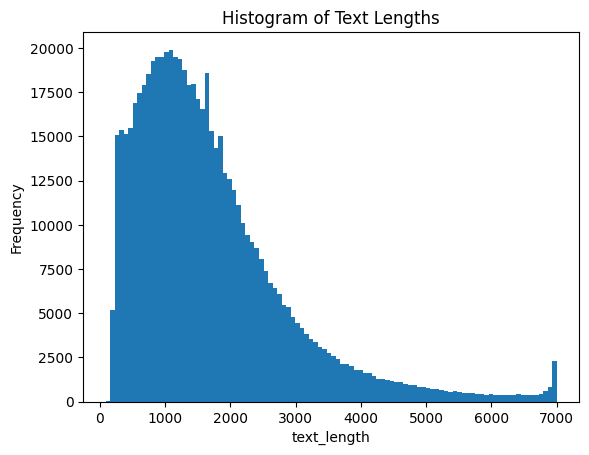

In [8]:
from utils import create_histogram

create_histogram(df, "text_length")

In [13]:
! pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.2 MB/s eta 0:00:00


In [14]:
import tiktoken
encoder = tiktoken.get_encoding("gpt2")  # older GPT-2 style
df['num_tokens'] = df['text'].apply(lambda x: len(encoder.encode(x)))
df.head()

,url,url_about,country_code,language,server,text,images_count,keep,length,clean_text,text_length,num_tokens
0,homegoodsboutique.com,homegoodsboutique.com/pages/about-us,US,en,shopify,About Us Buy More/Save More Sale - Up to 30% O...,2,No dup,206,,206,42
1,flexam.fr,flexam.fr/pages/about-flex-am-is-a-company,US,en,shopify,About FLEX AM is a company Have an account? Lo...,3,No dup,206,,203,56
2,hevenlyhomegoods.com,hevenlyhomegoods.com/pages/about-us,US,en,shopify,About Us Buy More/Save More Sale - Up to 30% O...,2,No dup,206,,206,42
3,fruitsfordrinks.com,fruitsfordrinks.com/pages/about,US,en,shopify,"Why Fruits for Drinks? Consistent, Efficient a...",0,No dup,206,,206,50
4,landecandleco.com,landecandleco.com/pages/about-us,US,en,shopify,About Us Hand Poured with love for Pets! 🐾 Use...,0,No dup,206,,203,55


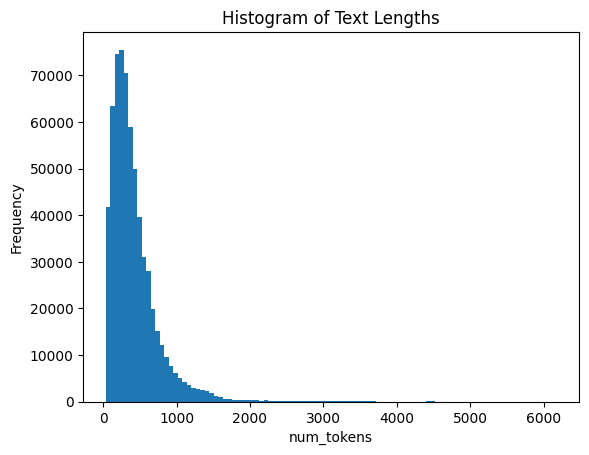

In [15]:
create_histogram(df, "num_tokens")

In [16]:
from utils import trim

df = trim(df, "num_tokens", [2,1500])

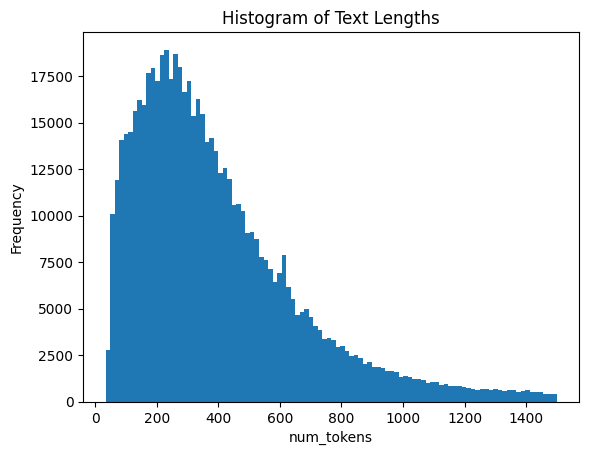

In [17]:
create_histogram(df, "num_tokens")

In [18]:
import pandas as pd

# Example: assume df has columns ["id", "text", "num_tokens"]
df_sorted = df.sort_values(by="num_tokens").copy()

# We'll store the original index so we can map back later,
# or you can just use "df['id']" if it is guaranteed unique.
df_sorted["orig_index"] = df_sorted.index

# Reset the DataFrame index so we can easily chunk it
df_sorted.reset_index(drop=True, inplace=True)


In [70]:
print(len(df_sorted))
display(df_sorted.head())

627995


,url,url_about,country_code,language,server,text,images_count,keep,length,clean_text,text_length,num_tokens,orig_index
0,aoi.deltaembroidery.com,aoi.deltaembroidery.com/pages/about-us,US,en,shopify,Contact Us If you are experiencing issues plea...,0,No dup,206,,206,34,229
1,unsulliedbody.com,unsulliedbody.com/pages/about-us,US,en,shopify,About Us Free Domestic Shipping To help people...,1,No dup,211,,211,35,1290
2,simplycleanservices.ca,simplycleanservices.ca/pages/about-us,US,en,shopify,"We prioritize professionalism, honesty, and re...",2,No dup,207,,207,35,248
3,novelbookstore.co,novelbookstore.co/pages/about-novel,PT,en,shopify,Cart Congratulations! Your order qualifies for...,4,No dup,211,,211,35,1369
4,iamthetee.com,iamthetee.com/pages/about-us,IN,en,shopify,About Us INFO SERVICES About UsWe are passiona...,0,No dup,207,,207,35,336


# Preparing Batch File
Batches start with a .jsonl file where each line contains the details of an individual request t

````json
{"custom_id": "request-1",
 "method": "POST", "url": "/v1/chat/completions",
 "body": {
     "model": "gpt-3.5-turbo-0125",
     "messages": [
    {
      "role": "system",
      "content": "You are a highly precise and reliable assistant. Your task is to extract and retain only the core 'About Us' content from the provided scraped text. Remove any extraneous elements such as headings, promotions, or button text that may appear at the beginning or end. If no clear 'About Us' section exists, return an empty response rather than generating one. If the text is not in English, translate it into English. Output only the cleaned and, if necessary, translated 'About Us' content, with no additional comments or formatting."
    },
    {
      "role": "user",
      "content": "PASTE_SCRAPED_TEXT_HERE"
    }
  ],
     "max_tokens": 1000}}
````

In [71]:
import pandas as pd
import json
import os

def create_batch_requests(df,BATCH_SIZE = 50000):
    # OpenAI batch limit
    total_batches = (len(df) // BATCH_SIZE) + (1 if len(df) % BATCH_SIZE != 0 else 0)

    # Define system message
    system_message = {
        "role": "system",
        "content": "You are a highly precise and reliable assistant. Your task is to extract and retain only the core 'About Us' content from the provided scraped text. Remove any extraneous elements such as headings, promotions, or button text that may appear at the beginning or end. If no clear 'About Us' section exists, return an empty response rather than generating one. If the text is not in English, translate it into English. Output only the cleaned and, if necessary, translated 'About Us' content, with no additional comments or formatting."
    }
    # Create output directory
    output_dir = "batch_requests"
    os.makedirs(output_dir, exist_ok=True)

    # Generate batch files in JSONL format
    for batch_num in range(total_batches):
        batch_start = batch_num * BATCH_SIZE
        batch_end = min((batch_num + 1) * BATCH_SIZE, len(df))
        batch_df = df.iloc[batch_start:batch_end]  # subset of the DataFrame

        batch_filename = f"{output_dir}/batch_{batch_num+1}.jsonl"

        with open(batch_filename, "w", encoding="utf-8") as f:
            # Iterate over rows in the current batch
            for i, row in batch_df.iterrows():
                text = row["text"]
                custom_id = f"request-{i}"  # <-- Use the df's "id" column
                max_tokens = row["num_tokens"]  # <-- Use the df's "num_tokens" column

                # Construct the request
                request = {
                    "custom_id": str(custom_id),   # convert to string just to be safe
                    "method": "POST",
                    "url": "/v1/chat/completions",
                    "body": {
                        "model": "gpt-4o-mini",
                        "messages": [
                            system_message,
                            {"role": "user", "content": text}
                        ],
                        "max_tokens": int(max_tokens)  # ensure it's an integer
                    }
                }
                # Write each JSON request object on its own line
                f.write(json.dumps(request, ensure_ascii=False) + "\n")

        print(f"Batch {batch_num+1}/{total_batches} saved: {batch_filename}")

    print(f"✅ All {total_batches} batches created successfully in JSONL format!")


In [72]:
create_batch_requests(df_sorted,BATCH_SIZE=1000)

Batch 1/628 saved: batch_requests/batch_1.jsonl
Batch 2/628 saved: batch_requests/batch_2.jsonl
Batch 3/628 saved: batch_requests/batch_3.jsonl
Batch 4/628 saved: batch_requests/batch_4.jsonl
Batch 5/628 saved: batch_requests/batch_5.jsonl
Batch 6/628 saved: batch_requests/batch_6.jsonl
Batch 7/628 saved: batch_requests/batch_7.jsonl
Batch 8/628 saved: batch_requests/batch_8.jsonl
Batch 9/628 saved: batch_requests/batch_9.jsonl
Batch 10/628 saved: batch_requests/batch_10.jsonl
Batch 11/628 saved: batch_requests/batch_11.jsonl
Batch 12/628 saved: batch_requests/batch_12.jsonl
Batch 13/628 saved: batch_requests/batch_13.jsonl
Batch 14/628 saved: batch_requests/batch_14.jsonl
Batch 15/628 saved: batch_requests/batch_15.jsonl
Batch 16/628 saved: batch_requests/batch_16.jsonl
Batch 17/628 saved: batch_requests/batch_17.jsonl
Batch 18/628 saved: batch_requests/batch_18.jsonl
Batch 19/628 saved: batch_requests/batch_19.jsonl


KeyboardInterrupt: 

In [73]:
display(df_sorted.head())

,url,url_about,country_code,language,server,text,images_count,keep,length,clean_text,text_length,num_tokens,orig_index
0,aoi.deltaembroidery.com,aoi.deltaembroidery.com/pages/about-us,US,en,shopify,Contact Us If you are experiencing issues plea...,0,No dup,206,,206,34,229
1,unsulliedbody.com,unsulliedbody.com/pages/about-us,US,en,shopify,About Us Free Domestic Shipping To help people...,1,No dup,211,,211,35,1290
2,simplycleanservices.ca,simplycleanservices.ca/pages/about-us,US,en,shopify,"We prioritize professionalism, honesty, and re...",2,No dup,207,,207,35,248
3,novelbookstore.co,novelbookstore.co/pages/about-novel,PT,en,shopify,Cart Congratulations! Your order qualifies for...,4,No dup,211,,211,35,1369
4,iamthetee.com,iamthetee.com/pages/about-us,IN,en,shopify,About Us INFO SERVICES About UsWe are passiona...,0,No dup,207,,207,35,336


In [74]:
import json

# Specify the JSONL file to check
jsonl_file = "batch_requests/batch_1.jsonl"  # Adjust the path if needed

# Read the first line (first request) from the JSONL file
with open(jsonl_file, "r", encoding="utf-8") as f:
    first_request = f.readline().strip()  # Read the first line and remove extra spaces

# Convert it to a dictionary and pretty print
if first_request:
    request_data = json.loads(first_request)
    print(json.dumps(request_data, indent=4, ensure_ascii=False))  # Pretty print JSON
else:
    print("Error: The JSONL file is empty or not formatted correctly.")


{
    "custom_id": "request-0",
    "method": "POST",
    "url": "/v1/chat/completions",
    "body": {
        "model": "gpt-4o-mini",
        "messages": [
            {
                "role": "system",
                "content": "You are a highly precise and reliable assistant. Your task is to extract and retain only the core 'About Us' content from the provided scraped text. Remove any extraneous elements such as headings, promotions, or button text that may appear at the beginning or end. If no clear 'About Us' section exists, return an empty response rather than generating one. If the text is not in English, translate it into English. Output only the cleaned and, if necessary, translated 'About Us' content, with no additional comments or formatting."
            },
            {
                "role": "user",
                "content": "Contact Us If you are experiencing issues please refresh the page Welcome Auto Owners Agents For further questions about sales, please contact D

# upload the .jsonl Batch file

In [75]:
from openai import OpenAI
from my_secrets import OPENAI_API_KEY
client = OpenAI(api_key=OPENAI_API_KEY)

batch_input_file = client.files.create(
    file=open("batch_requests/batch_1.jsonl","rb"),
    purpose="batch"
)

print(batch_input_file)

FileObject(id='file-HThh66mAwWi8jS5a4MW1c6', bytes=960722, created_at=1741013752, filename='batch_1.jsonl', object='file', purpose='batch', status='processed', status_details=None, expires_at=None)


In [53]:
files = client.files.list()
print(files)

SyncCursorPage[FileObject](data=[FileObject(id='file-4d8PPLj8fMVyXpgTzwGcLL', bytes=576679, created_at=1741011840, filename='batch_1.jsonl', object='file', purpose='batch', status='processed', status_details=None, expires_at=1743603840)], object='list', has_more=False, first_id='file-4d8PPLj8fMVyXpgTzwGcLL', last_id='file-4d8PPLj8fMVyXpgTzwGcLL')


# Creating the Batch
Once you've successfully uploaded your input file, you can use the input File object's ID to create a batch. In this case, let's assume the file ID is file-abc123. For now, the completion window can only be set to 24h. You can also provide custom metadata via an optional metadata parameter.

In [59]:
!wc -l batch_requests/batch_1.jsonl

500 batch_requests/batch_1.jsonl


In [76]:
current_batch = client.batches.create(
    input_file_id=batch_input_file.id,  # or whatever your variable name is
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
        "description": "nightly eval job"
    }
)

this should be the output:
```python
{
  "id": "batch_abc123",
  "object": "batch",
  "endpoint": "/v1/chat/completions",
  "errors": null,
  "input_file_id": "file-abc123",
  "completion_window": "24h",
  "status": "validating",
  "output_file_id": null,
  "error_file_id": null,
  "created_at": 1714508499,
  "in_progress_at": null,
  "expires_at": 1714536634,
  "completed_at": null,
  "failed_at": null,
  "expired_at": null,
  "request_counts": {
    "total": 0,
    "completed": 0,
    "failed": 0
  },
  "metadata": null
}
````

# Checking the Status of a Batch

In [82]:

print(current_batch.status)

validating


### status can be:

Status	        Description
validating	    the input file is being validated before the batch can begin
failed	the     input file has failed the validation process
in_progress	    the input file was successfully validated and the batch is currently being run
finalizing	    the batch has completed and the results are being prepared
completed	    the batch has been completed and the results are ready
expired	the     batch was not able to be completed within the 24-hour time window
cancelling	    the batch is being cancelled (may take up to 10 minutes)
cancelled	    the batch was cancelled

#  Retrieving the Results

Note that the output line order may not match the input line order. Instead of relying on order to process your results, use the custom_id field which will be present in each line of your output file and allow you to map requests in your input to results in your output.

In [ ]:
from openai import OpenAI
client = OpenAI()

file_response = client.files.content("file-xyz123")
print(file_response.text)